In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

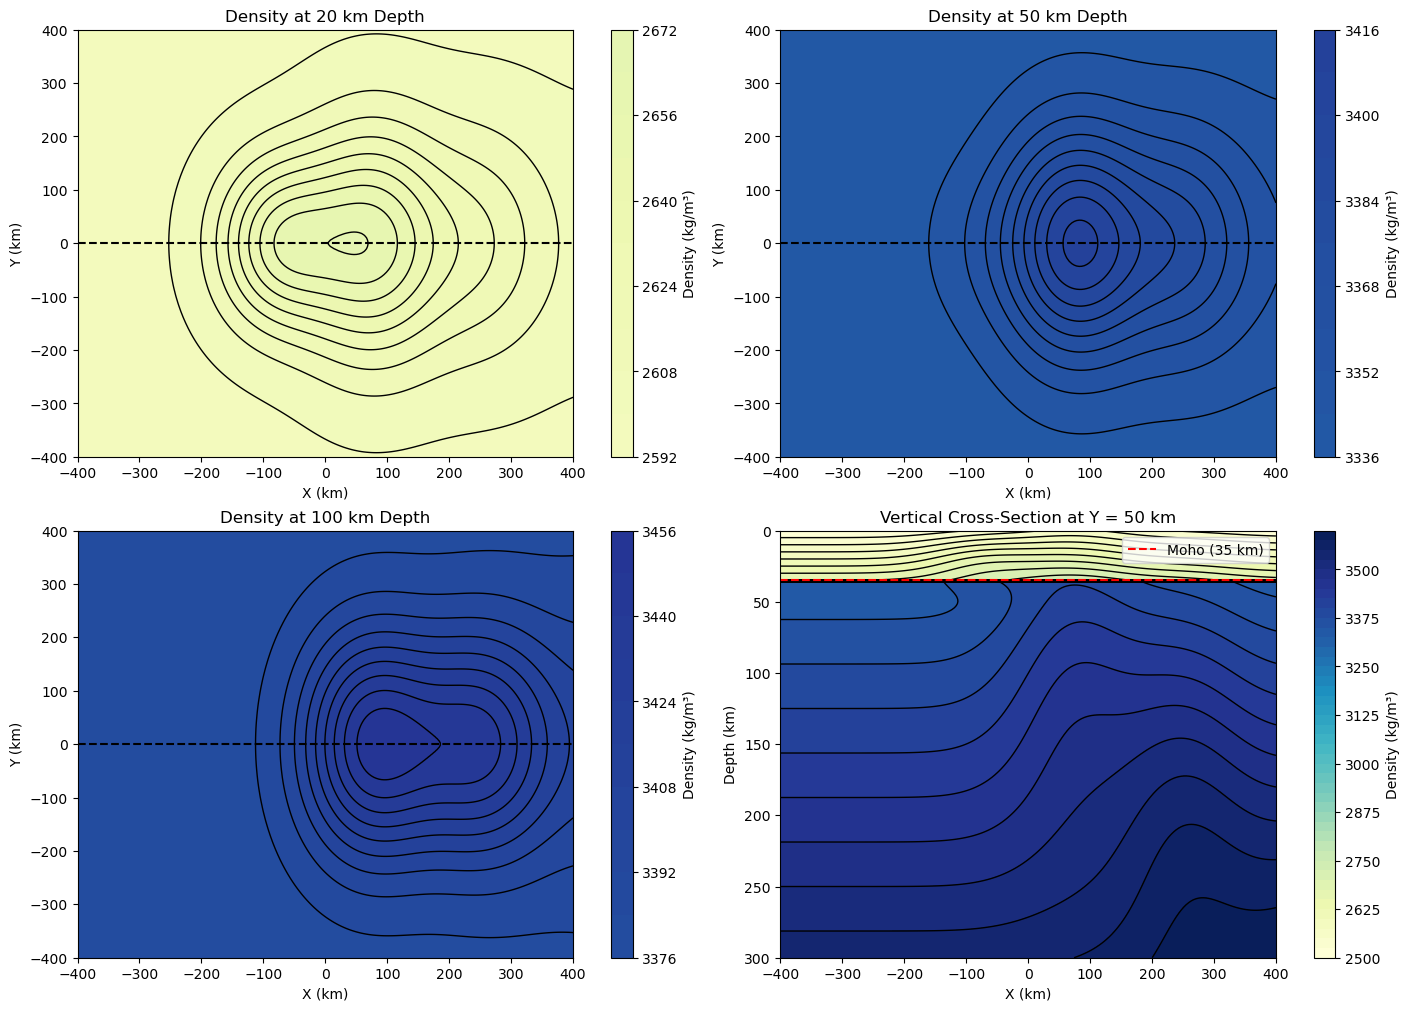

In [3]:
# Define the physical domain
region = 400e3
depth = 300e3
nxy = 200
nz = 200

x = np.linspace(-region, region, nxy)
y = np.linspace(-region, region, nxy)
z = np.linspace(0, depth, nz)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Define 3D Gaussian anomaly
def gaussian_3d(x0, y0, z0, sigma_x, sigma_y, sigma_z, rho0):
    return rho0 * np.exp(-((X - x0)**2 / (2 * sigma_x**2) +
                           (Y - y0)**2 / (2 * sigma_y**2) +
                           (Z - z0)**2 / (2 * sigma_z**2)))

# Anomalies
anomaly1 = gaussian_3d(-75e3, 0e3, 20e3, 70e3, 110e3, 15e3, 50)
anomaly2 = gaussian_3d(75e3, 0e3, 80e3, 80e3, 150e3, 100e3, 70)
anomaly3 = gaussian_3d(250e3, 0e3, 170e3, 80e3, 150e3, 100e3, 70)
anomaly4 = gaussian_3d(500e3, 0e3, 250e3, 150e3, 200e3, 100e3, 70)

# Combine anomalies
rho_3d = anomaly1 + anomaly2 + anomaly3 + anomaly4

# Background density profile
z_moho = 35e3
rho_crust, rho_mantle = 2500, 3300
alpha_crust, alpha_mantle = 0.005, 0.0008
rho_background_1d = np.where(z < z_moho,
                             rho_crust + alpha_crust * z,
                             rho_mantle + alpha_mantle * z)
rho_background_3d = np.broadcast_to(rho_background_1d, X.shape)

# Final model
rho_total = rho_background_3d + rho_3d

# Cross-section at Y km
y_target = 0e3
iy = np.argmin(np.abs(y - y_target))
rho_cross_section = rho_total[:, iy, :]

# Horizontal slices
z_slices_km = [20, 50, 100]
z_indices = [np.argmin(np.abs(z - z_km * 1e3)) for z_km in z_slices_km]
slices = [rho_total[:, :, idx] for idx in z_indices]

vmin = np.min(rho_total)
vmax = np.max(rho_total)

# Plot setup
fig, axs = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

# Plot horizontal maps
for ax, rho_slice, z_km in zip(axs.flat[:3], slices, z_slices_km):
    im = ax.contourf(x / 1e3, y / 1e3, rho_slice.T, levels=10, cmap='YlGnBu', vmin=vmin, vmax=vmax)
    imc = ax.contour(x / 1e3, y / 1e3, rho_slice.T, levels=10, colors='black', linewidths=1)
    ax.axhline(0, color='black', linestyle='--', linewidth=1.5)
    ax.set_title(f'Density at {z_km} km Depth')
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    fig.colorbar(im, ax=ax, label='Density (kg/m³)')

# Plot vertical cross-section
ax = axs[1, 1]
cf = ax.contourf(x / 1e3, z / 1e3, rho_cross_section.T, levels=50, cmap='YlGnBu', vmin=vmin, vmax=vmax)
c = ax.contour(x / 1e3, z / 1e3, rho_cross_section.T, levels=50, colors='black', linewidths=1)
ax.axhline(35, color='red', linestyle='--', linewidth=1.5, label='Moho (35 km)')
ax.set_title('Vertical Cross-Section at Y = 50 km')
ax.set_xlabel('X (km)')
ax.set_ylabel('Depth (km)')
ax.invert_yaxis()
ax.legend()
fig.colorbar(cf, ax=ax, label='Density (kg/m³)')

plt.show()


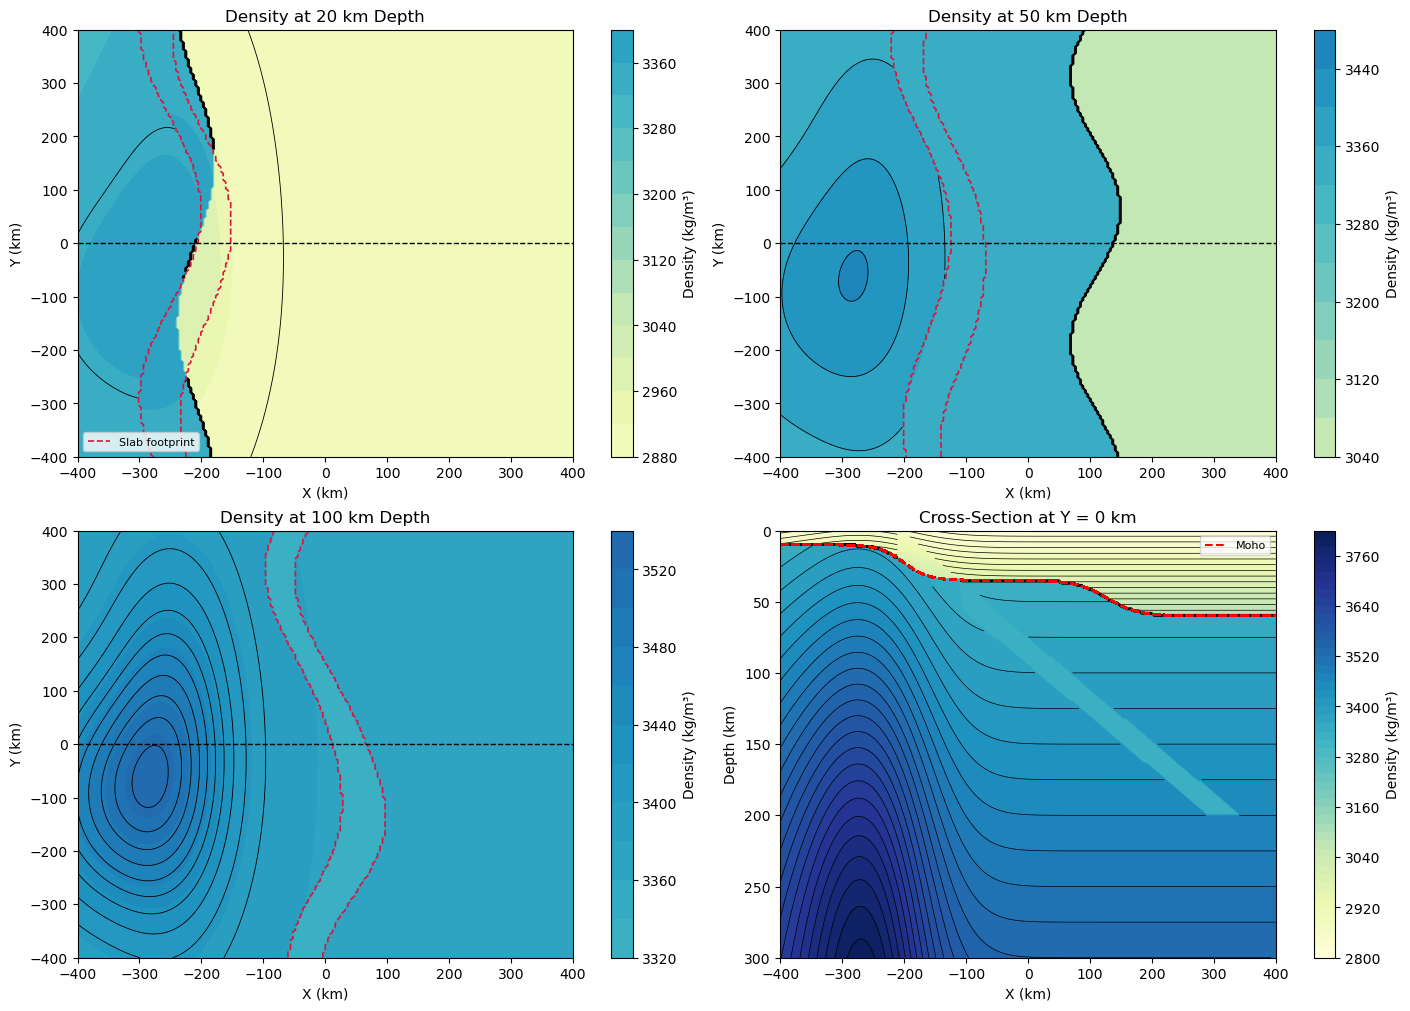

In [100]:
# ------------------------
# Grid / domain
# ------------------------
region = 400e3
depth  = 300e3
nxy    = 200
nz     = 200

x = np.linspace(-region, region, nxy)
y = np.linspace(-region, region, nxy)
z = np.linspace(0, depth, nz)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

def sin_wiggle(Y, amp, L, phase=0.0):
    """Return a sinusoidal offset (in meters) varying along Y."""
    return amp * np.sin(2*np.pi*Y / L + phase)

# ------------------------
# Moho geometry
# ------------------------
z_moho_oc   = 10e3
z_moho_cc   = 35e3
z_moho_deep = 60e3

# Transition 1 (oceanic-continental)
x_tr1_center = -200e3
w1 = 40e3
A1 = 30e3          # amplitude of wiggle (m)
L1 = 600e3         # wavelength (m)
x_tr1 = x_tr1_center + sin_wiggle(Y, A1, L1)

# Transition 2
x_tr2_center = 100e3
w2 = 50e3
A2 = 40e3
L2 = 500e3
x_tr2 = x_tr2_center + sin_wiggle(Y, A2, L2, phase=np.pi/4)

z_moho_surface = (
    z_moho_oc
    + (z_moho_cc  - z_moho_oc ) * 0.5 * (1 + np.tanh((X - x_tr1)/w1))
    + (z_moho_deep - z_moho_cc) * 0.5 * (1 + np.tanh((X - x_tr2)/w2))
)
z_moho_surface = np.minimum(z_moho_surface, z_moho_deep)

# ------------------------
# Slab geometry
# ------------------------
x_trench_center = -250e3
Atr = 50e3
Ltr = 700e3
x_trench = x_trench_center + sin_wiggle(Y, Atr, Ltr, phase=np.pi/3)

dip_base = 20.0
dip_var  = 5.0
dip = np.deg2rad(dip_base + dip_var * np.sin(2*np.pi*Y / 800e3))

s = X - x_trench  # horizontal distance from trench
z_slab_top = np.where(s > 0, s * np.tan(dip), np.nan)

# Thickness
slab_thickness = 20e3
z_slab_bottom  = z_slab_top + slab_thickness

# Depth cutoff
z_cut = 200e3
slab_mask = (Z >= z_slab_top) & (Z <= z_slab_bottom) & (s > 0) & (Z <= z_cut)

# ------------------------
# Densities
# ------------------------
rho_crust,  rho_mantle  = 2800.0, 3300.0
alpha_crust, alpha_mantle = 0.005, 0.0008  # kg/m^3

rho_background = np.where(Z < z_moho_surface,
                          rho_crust  + alpha_crust  * Z,
                          rho_mantle + alpha_mantle * Z)

# Slab contrast
rho_slab_contrast = 30.0
rho_background[slab_mask] += rho_slab_contrast
rho_background = np.where(slab_mask,
                          np.minimum(rho_background, rho_mantle + 30),
                          rho_background)

# Define 3D Gaussian anomaly
def gaussian_3d(x0, y0, z0, sigma_x, sigma_y, sigma_z, rho0):
    return rho0 * np.exp(-((X - x0)**2 / (2 * sigma_x**2) +
                           (Y - y0)**2 / (2 * sigma_y**2) +
                           (Z - z0)**2 / (2 * sigma_z**2)))

# Anomalies
anomaly1 = gaussian_3d(-250e3,  0e3, 300e3, 70e3, 220e3, 170e3, 200)
anomaly2 = gaussian_3d(-350e3, -100e3, 250e3, 90e3, 150e3, 150e3, 150)

# Combine anomalies
rho_anomaly = anomaly1 +anomaly2

rho_total = rho_background + rho_anomaly

# ------------------------
# Sections / slices
# ------------------------
y_target = 0.0
iy = np.argmin(np.abs(y - y_target))
rho_cross_section = rho_total[:, iy, :]
slab_mask_cs      = slab_mask[:, iy, :]

z_slices_km = [20, 50, 100]
z_indices = [np.argmin(np.abs(z - z_km * 1e3)) for z_km in z_slices_km]
slices = [rho_total[:, :, idx] for idx in z_indices]
slab_masks_xy = [slab_mask[:, :, idx] for idx in z_indices]

vmin, vmax = rho_total.min(), rho_total.max()

# ------------------------
# Plotting
# ------------------------
fig, axs = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

for i, (ax, rho_slice, slab_slice, z_km) in enumerate(zip(axs.flat[:3], slices, slab_masks_xy, z_slices_km)):
    im = ax.contourf(x/1e3, y/1e3, rho_slice.T, levels=12, cmap='YlGnBu', vmin=vmin, vmax=vmax)

    # Slab outline (red dashed)
    slab_int = slab_slice.T.astype(int)
    cs_slab = ax.contour(x/1e3, y/1e3, slab_int, levels=[0.5],
                         colors='crimson', linewidths=1.2, linestyles='--')

    # Mask slab for isolines
    rho_masked = np.ma.masked_where(slab_slice.T, rho_slice.T)
    ax.contour(x/1e3, y/1e3, rho_masked, levels=10, colors='black', linewidths=0.6)

    ax.axhline(0, color='black', linestyle='--', linewidth=1.0)
    ax.set_title(f'Density at {z_km} km Depth')
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    fig.colorbar(im, ax=ax, label='Density (kg/m³)')

    if i == 0:
        slab_proxy = Line2D([0], [0], color='crimson', lw=1.2, ls='--', label='Slab footprint')
        ax.legend(handles=[slab_proxy], loc='lower left', fontsize=8)

# ---- cross-section ----
ax = axs[1, 1]
cf = ax.contourf(x/1e3, z/1e3, rho_cross_section.T, levels=50, cmap='YlGnBu', vmin=vmin, vmax=vmax)
rho_cs_masked = np.ma.masked_where(slab_mask_cs.T, rho_cross_section.T)
ax.contour(x/1e3, z/1e3, rho_cs_masked, levels=50, colors='black', linewidths=0.5)

h_moho = ax.plot(x/1e3, z_moho_surface[:, iy]/1e3, 'r--', lw=1.5, label='Moho')[0]

ax.set_title(f'Cross-Section at Y = {y_target/1e3:.0f} km')
ax.set_xlabel('X (km)')
ax.set_ylabel('Depth (km)')
ax.invert_yaxis()
ax.legend([h_moho], ['Moho'], loc='upper right', fontsize=8)
fig.colorbar(cf, ax=ax, label='Density (kg/m³)')

plt.show()

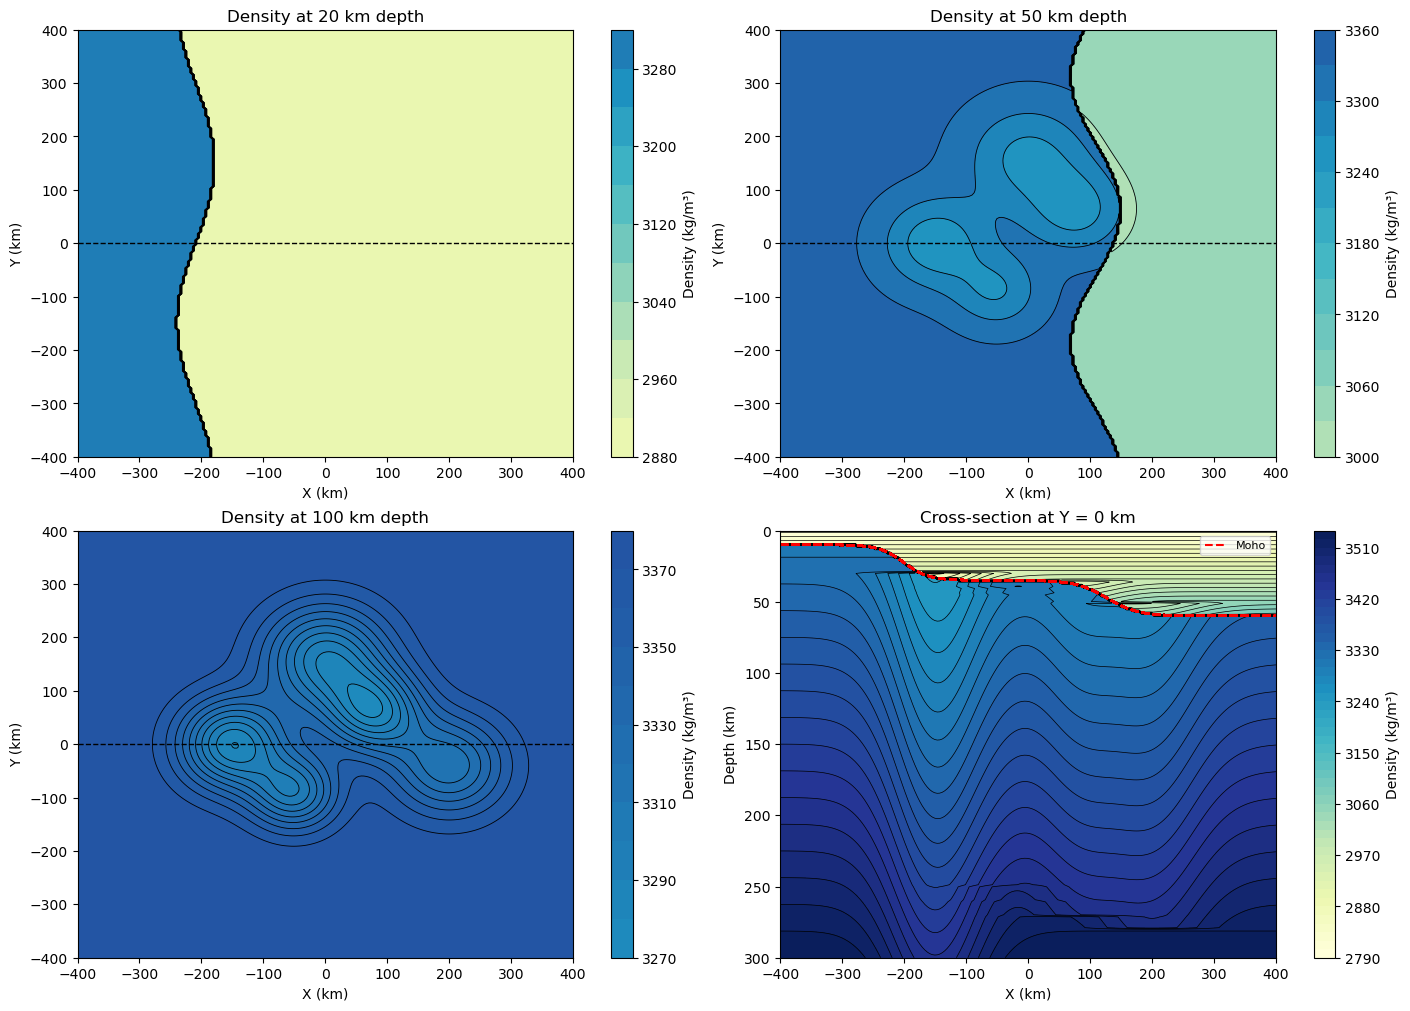

In [105]:
# ---------------------------------------------------------------------
# 3-D density model with 5 mantle plumes
# ---------------------------------------------------------------------

# --------------------------------------------------
# 1. Grid / domain
# --------------------------------------------------
region = 400e3          # half-width in X and Y (m)
depth  = 300e3          # maximum model depth (m)
nxy    = 200            # number of nodes in X and Y
nz     = 200            # number of nodes in Z

x = np.linspace(-region, region, nxy)
y = np.linspace(-region, region, nxy)
z = np.linspace(0, depth,  nz )
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# --------------------------------------------------
# 2. Moho geometry
# --------------------------------------------------
def sin_wiggle(Y, amp, L, phase=0.0):
    """Sinusoidal cross-strike wiggle used for Moho undulations."""
    return amp * np.sin(2*np.pi*Y / L + phase)

z_moho_oc, z_moho_cc, z_moho_deep = 10e3, 35e3, 60e3

# transition 1 oceanic-continental
x_tr1_center, w1, A1, L1 = -200e3, 40e3, 30e3, 600e3
x_tr1 = x_tr1_center + sin_wiggle(Y, A1, L1)

# transition 2
x_tr2_center, w2, A2, L2 = 100e3, 50e3, 40e3, 500e3
x_tr2 = x_tr2_center + sin_wiggle(Y, A2, L2, phase=np.pi/4)

# Final Moho depth
z_moho_surface = (
      z_moho_oc
    + (z_moho_cc  - z_moho_oc )*0.5*(1 + np.tanh((X - x_tr1)/w1))
    + (z_moho_deep - z_moho_cc)*0.5*(1 + np.tanh((X - x_tr2)/w2))
)
z_moho_surface = np.minimum(z_moho_surface, z_moho_deep)

# --------------------------------------------------
# 3. Background lithosphere density
# --------------------------------------------------
rho_crust,   rho_mantle   = 2800.0, 3300.0        
alpha_crust, alpha_mantle = 0.005,  0.0008         

rho_background = np.where(
    Z < z_moho_surface,
    rho_crust  + alpha_crust  * Z,
    rho_mantle + alpha_mantle * Z
)

# --------------------------------------------------
# 4. Mantle plume definition
# --------------------------------------------------
def plume_3d(x0, y0, r0, z_top, z_bot, drho0,
             sigma_r=None, sigma_z=None):
    
    sigma_r = r0        if sigma_r is None else sigma_r
    sigma_z = (z_bot - z_top) if sigma_z is None else sigma_z
    r2      = (X - x0)**2 + (Y - y0)**2
    # vertical taper: 1 inside [z_top, z_bot]; Gaussian shoulders
    depth_term = np.exp(-((Z - (z_top + z_bot)/2)**2)/(2*sigma_z**2))
    radial_term = np.exp(-(r2)/(2*sigma_r**2))
    mask_z = (Z >= z_top) & (Z <= z_bot)
    return drho0 * radial_term * depth_term * mask_z

# --------------------------------------------------
# 5. Configure the five plumes
# --------------------------------------------------
plume_specs = np.array([
    [-150,   0,   60,   30, 300, -100],
    [ -50, -90,   50,   40, 250, -75],
    [  80,  60,   55,   35, 270, -85],
    [ 200, -40,   65,   50, 280, -70],
    [   0, 160,   70,   45, 260, -90],
]) * np.array([1e3,1e3,1e3,1e3,1e3,1])

# Build composite plume anomaly
rho_plume = np.zeros_like(rho_background)
for xc, yc, rc, zt, zb, drho in plume_specs:
    rho_plume += plume_3d(xc, yc, rc, zt, zb, drho)

# --------------------------------------------------
# 6. Total density field
# --------------------------------------------------
rho_total = rho_background + rho_plume

y_target = 0.0
iy = np.argmin(abs(y - y_target))
rho_cross_section = rho_total[:, iy, :]

z_slices_km = [20, 50, 100]
z_indices    = [np.argmin(abs(z - zs*1e3)) for zs in z_slices_km]
slices       = [rho_total[:, :, iz] for iz in z_indices]

vmin, vmax = rho_total.min(), rho_total.max()

fig, axs = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

# --- horizontal slices -------------------------------------------------
for i, (ax, rho_xy, z_km) in enumerate(zip(axs.flat[:3], slices, z_slices_km)):
    cf = ax.contourf(x/1e3, y/1e3, rho_xy.T, levels=12,
                     cmap='YlGnBu', vmin=vmin, vmax=vmax)
    ax.contour(x/1e3, y/1e3, rho_xy.T, levels=10, colors='black', linewidths=0.6)
    ax.axhline(0, color='k', ls='--', lw=1)
    ax.set_title(f'Density at {z_km} km depth')
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    fig.colorbar(cf, ax=ax, label='Density (kg/m³)')

    if i == 0:
        plume_proxy = Line2D([0], [0], marker='o', color='none',
                             markerfacecolor='k', markersize=6)

# --- cross-section -----------------------------------------------------
ax = axs[1, 1]
cf = ax.contourf(x/1e3, z/1e3, rho_cross_section.T, levels=50,
                 cmap='YlGnBu', vmin=vmin, vmax=vmax)
ax.contour(x/1e3, z/1e3, rho_cross_section.T, levels=50, colors='black', linewidths=0.5)

h_moho = ax.plot(x/1e3, z_moho_surface[:, iy]/1e3, 'r--', lw=1.5, label='Moho')[0]

ax.plot(x/1e3, z_moho_surface[:, iy]/1e3, 'r--', lw=1.5, label='Moho')
ax.set_title(f'Cross-section at Y = {y_target/1e3:.0f} km')
ax.set_xlabel('X (km)')
ax.set_ylabel('Depth (km)')
ax.invert_yaxis()
ax.legend([h_moho], ['Moho'], loc='upper right', fontsize=8)
fig.colorbar(cf, ax=ax, label='Density (kg/m³)')

plt.show()
